# Sound Mapping with WideNoise

http://cs.everyaware.eu/event/widenoise

Workflow:

1. Use iPhone app WideNoisePlus to record decible levels.

2. Decible measurements with associated GPS coordinates are automatically stored [here](http://cs.everyaware.eu/event/widenoise/personal).

3. Measurements can be downloaded as a KML file and parsed using two python functions I created below

Open xml file and read it into a python dictionary.

In [3]:
import xmltodict
with open('Sound Map/file2.xml') as fd:
    doc = xmltodict.parse(fd.read())

Define a function to retrieve the lat/lon coordinates from the data above.

In [4]:
def getCoords(doc):
    '''
    Input: xml file from EveryAware WideNoise project
    Output: list of the lat/lon coordinates
    '''
    coords = []

    for rec in doc['kml']['Document']['Placemark']:
        coords.append(rec['ExtendedData']['Data'][1]['value'].replace('[','').strip().split()[:2])

    return coords

Define a function to retrieve the noise decible recordings.

In [5]:
def getDecibels(doc):
    '''
    Input: xml file from EveryAware WideNoise project
    Output: list of the decible measurements
    '''
    decibels = []

    for rec in doc['kml']['Document']['Placemark']:
        decibels.append(rec['ExtendedData']['Data'][7]['value'].strip())

    return decibels

Combine coords and decibles into a data table, parse for lat and lons.

In [6]:
import pandas as pd

def createTable(doc):
    '''
    Input: xml file from EveryAware WideNoise project
    Output: pandas dataframe containing decibles and lat/lon coordinates
    '''
    df = pd.DataFrame({'Location': getCoords(doc), 'Decibels':getDecibels(doc)})
    df['Latitude'] = [rec[1][0:df['Location'][0][1].find(',')].encode('ascii','ignore') for rec in df.Location]
    df['Longitude'] = [rec[0][0:df['Location'][0][0].find(',')].encode('ascii','ignore') for rec in df.Location]

    return df

df = createTable(doc)

# save to csv
df.to_csv('soundmap.csv')
df.head()

,Decibels,Location,Latitude,Longitude
0,79.166489,"[-73.971978,, 40.68814,]",40.68814,-73.971978
1,90.824547,"[-73.972033,, 40.688094,]",40.68809,-73.972033
2,88.532661,"[-73.971983,, 40.688078,]",40.68807,-73.971983
3,77.046959,"[-73.971867,, 40.688095,]",40.68809,-73.971867
4,82.685875,"[-73.972053,, 40.687536,]",40.68753,-73.972053


Make a few plots.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [48]:
# Convert decibles to float
df.Decibels = df.Decibels.astype(float)
decibels = np.array(df.Decibels)

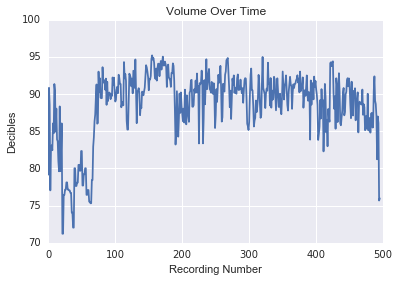

In [52]:
# Plot volume over time
fig, ax = plt.subplots()
ax.plot(decibels)
ax.set_title('Volume Over Time')
ax.set_xlabel('Recording Number')
ax.set_ylabel('Decibles');

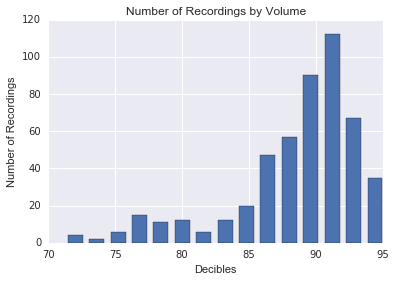

In [50]:
# Generate histogram
hist, bins = np.histogram(decibels, bins=15)
width = .7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

fig, ax = plt.subplots()
ax.bar(center, hist, align='center', width=width)
ax.set_title('Number of Recordings by Volume')
ax.set_xlabel('Decibles')
ax.set_ylabel('Number of Recordings');

Let's categorize the recordings by volume level so that we can color code our map by category. Let all recordings less than 85 decibles be 'Quiet', all between 85 and 90 be 'Moderate', and all above 90 be 'Loud'.

In [70]:
volume_categories = []
for i in df.Decibels:
    if i < 85.0:
        volume_categories.append('Quiet: < 85 decibles')
    elif 85.0 <= i <= 90:
        volume_categories.append('Moderate: 85 to 90 decibles')
    elif i > 90:
        volume_categories.append('Loud: > 90 decibles')

In [73]:
# Insert as a new column in the dataframe
df['Volume Category'] = volume_categories
df.head()

,Decibels,Location,Latitude,Longitude,Volume Category
0,79.166489,"[-73.971978,, 40.68814,]",40.68814,-73.971978,Quiet: < 85 decibles
1,90.824547,"[-73.972033,, 40.688094,]",40.68809,-73.972033,Loud: > 90 decibles
2,88.532661,"[-73.971983,, 40.688078,]",40.68807,-73.971983,Moderate: 85 to 90 decibles
3,77.046959,"[-73.971867,, 40.688095,]",40.68809,-73.971867,Quiet: < 85 decibles
4,82.685875,"[-73.972053,, 40.687536,]",40.68753,-73.972053,Quiet: < 85 decibles


In [74]:
# save to csv
df.to_csv('soundmap.csv')

# Mapping with Carto

In [75]:
from IPython.display import IFrame
IFrame("https://willgeary.carto.com/viz/b6a4e576-a6c8-11e6-b3a9-0ecd1babdde5/embed_map", 800, 500)